# Train a force field from scratch

This guide shows how to train a force field model from scratch using the NFFLr trainer from the command line.

We'll focus on a small ALIGNN model trained on the `mlearn` Silicon dataset using a single GPU.

- set up the environment
- create configuration files
- allocate an interactive GPU session and tune the batch size to maximize GPU utilization
- finalize config and train
- plot metrics
- evaluate properties

## environment

## initial configuration file

Start with an initial configuration file `config.py` that defines the variables
- `args`: the training arguments (`nfflr.train.TrainingConfig`)
- `model`: a force field model (`nfflr.models.ALIGNNFF` in this case)
- `dataset`: a `nfflr.AtomsDataset` configured to yield force field targets

The NFFLr trainer scripts will use [py-config-runner](https://py-config-runner.readthedocs.io/en/latest/) to parse this configuration,
so arbitrary python is allowed, and the required variables may appear in any order.

### training configuration section

In addition to the usual hyperparameters related to the actual optimization process (e.g., learning rate),
it can be important to enable asynchronous pre-computation of input representations by setting the `diskcache` argument
to a directory that (1) you have write permissions for and (2) is on a fast local filesystem, like a directory under `/tmp`
or a dedicated scratch partition if you're running in an HPC setting.

Additionally setting a non-zero `dataloader_workers` will help reduce the latency of fetching batches of data during training.
If you're using SLURM, make sure to request a large enough `cpu` allocation for the additional dataloader processes.

```python
# config.py
from pathlib import Path
import nfflr

criterion = nfflr.nn.MultitaskLoss(
    tasks=["energy", "forces"],
    weights=[0.5, 0.5]
)

args = nfflr.train.TrainingConfig(
    experiment_dir=Path(__file__).parent.resolve(),
    random_seed=42,
    dataloader_workers=4,
    criterion=criterion,
    epochs=100,
    per_device_batch_size=8,
    weight_decay=1e-3,
    learning_rate=5e-4,
    warmup_steps=0.1,
    diskcache="/tmp/bld",
    initialize_bias=True,
    initialize_estimated_reference_energies=True,
)
...
```



### model section

When training ALIGNN models with large batch sizes, computation of the line graph (which is done on CPU) can become a bottleneck.
Since `transform` can be an arbitrary `Callable`, a straightforward way to mitigate this bottleneck is to wrap the base `transform`
in a custom function `precomputed_line_graph_tuple`.

```{caution} Precomputed transforms must not include operations that require an autograd trace.
This could introduce correctness issues for both training and autograd-based atomic force prediction.
Precomputing neighbor lists is fine, but precomputing bond lengths or geometry-dependent basis functions is not.
```

```python
# config.py (continued)

rcut = 4.5
transform = nfflr.nn.PeriodicRadiusGraph(cutoff=rcut)
model_cfg = nfflr.models.ALIGNNFFConfig(
    transform=transform,
    cutoff=nfflr.nn.Cosine(rcut),
    local_cutoff=rcut,
    atom_features="embedding",
    reference_energies="trainable",
    alignn_layers=2,
    gcn_layers=2,
    compute_forces=True,
)
model = nfflr.models.ALIGNNFF(model_cfg)
```


### dataset section

The dataset (mlearn `Si`) is specified last - it currently relies on explicit specification of the `transform` for asynchronous graph computation and the `diskcache` configuration:

```python
# config.py (continued)

dataset = nfflr.data.mlearn_dataset(
    elements="Si",
    transform=model.transform,
    diskcache=args.diskcache
)
```

## tune batch size to maximize GPU utilization

Next, we conduct some [learning rate tests](https://arxiv.org/abs/1506.01186) to 
1. select a batch size that maximizes GPU utilization on the available hardware and 
2. identify an appropriate learning rate (and potentially weight decay) setting for our dataset and batch size.

This is best done in an interactive session, running the learning rate finder in one window and monitoring the output of `nvidia-smi` in another.

If you're running on a SLURM-based cluster, allocate an interactive session with one GPU:
```shell
srun --pty --partition=gpu --time=2:00:00 --gres=gpu:1 -c 4 bash
conda activate nfflr
nvidia-smi
```

```shell
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   49C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
```

This session has allocated a single P100 GPU with 16 GiB VRAM.
The important fields are the memory utilization and volatile GPU utilization
(both at zero here because no code is running on the GPU yet).

### assessing GPU utilization

For a given model configuration, GPU allocation, and batch size, the best training throughput should maximize the utilization of the GPU.
Run the learning rate finder, and monitor the output of `nvidia-smi` to assess the affect of changing the batch size.

```shell
nff lr config.py
```

```{note} It's nice to run these checks with [gpustat](https://github.com/wookayin/gpustat)
running in a split-pane [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) window.

`gpustat` provides a convenient summary of the important GPU utilization stats,
and a 100 ms refresh rate typically gives a reasonable idea of the fluctations in GPU utilization.


```shell
tmux 
[CTRL-b "]  # split window vertically
python -m gpustat -i 0.1
[CTRL-b o] # switch panes
nff lr config.py
```






<img src="./force-field-training/ff-scratch-lr-bs-8.png" alt="drawing" width="60%"/>

The batch size of 8 that we started with seems reasonable - GPU utilization is consistently around 100 %, and the memory utilization is hovering around 70 % of the available VRAM.

Now that we have this data point, there's no need to run the learning rate finder to completion at this point.
We can try doubling the batch size to 16 - in this case we find the GPU memory limit!

<img src="./force-field-training/ff-scratch-lr-bs-16.png" alt="drawing" width="60%"/>

If we back off a bit to a batch size of 12, it seems to be reasonably stable with a memory utilization hovering around 90 % of available VRAM.
It's prudent to leave some head space, especially for datasets with high variability in the number of atoms in the training configurations, which can lead to spikes in memory utilization and out-of-memory woes during production training runs.

<img src="./force-field-training/ff-scratch-lr-bs-12.png" alt="drawing" width="60%"/>

```{note} If the compute utilization fluctuates a lot (especially if there are bursts of high and low utilization), this likely indicates that the dataloader (or some other CPU-bound process) cannot keep up with the GPU.

Try increasing the number of dataloader workers (4 per GPU is probably a reasonable max) and/or making sure the `diskcache` setting is configured to use a fast local filesystem. If the workload is still volatile, use the [pytorch profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html) to identify the bottleneck.
```

Now that we've identified a reasonable batch size that maximizes GPU utilization, run the learning rate test out to completion:

<img src="./force-field-training/lr.png" alt="drawing" width="80%"/>

```{note}
On such a small dataset this exercise is somewhat overkill, since the learning rate finder runs 400 iterations (25 epochs on this training set with a batch size of 12!).
However, on large datasets the learning rate finder often completes in a fraction of an epoch.
```

Based on the learning rate test, let's choose a peak learning rate of 5e-4. [^n1]

[^n1]: Running the learning rate finder over a range of weight decay settings can be a reasonable strategy for identifying reasonable settings for both the learning rate and weight decay.

## production training run

After finalizing these settings choices in the configuration file,


````{admonition} full configuration script (config.py)
:class: dropdown

```python
# config.py
from pathlib import Path
import nfflr

criterion = nfflr.nn.MultitaskLoss(
    tasks=["energy", "forces"],
    weights=[0.5, 0.5]
)

args = nfflr.train.TrainingConfig(
    experiment_dir=Path(__file__).parent.resolve(),
    random_seed=42,
    dataloader_workers=4,
    criterion=criterion,
    epochs=100,
    per_device_batch_size=12,
    weight_decay=1e-3,
    learning_rate=5e-4,
    warmup_steps=0.1,
    diskcache="/tmp/bld",
    initialize_bias=True,
    initialize_estimated_reference_energies=True,
)

rcut = 4.5
transform = nfflr.nn.PeriodicRadiusGraph(cutoff=rcut)
model_cfg = nfflr.models.ALIGNNFFConfig(
    transform=transform,
    cutoff=nfflr.nn.Cosine(rcut),
    local_cutoff=rcut,
    atom_features="embedding",
    reference_energies="trainable",
    alignn_layers=2,
    gcn_layers=2,
    compute_forces=True,
)
model = nfflr.models.ALIGNNFF(model_cfg)

dataset = nfflr.data.mlearn_dataset(
    elements="Si",
    transform=model.transform,
    diskcache=args.diskcache
)

```
````


launch a production training run with  `nff train config.py`.

Once the training run completes, you can inspect the loss curves that are written to `metric_history.pkl`:

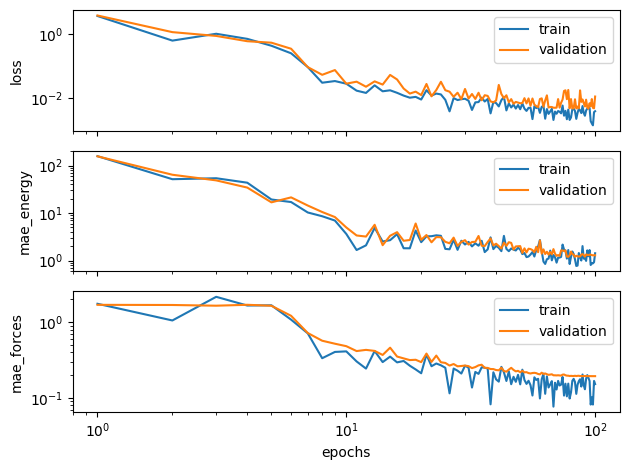

In [1]:
from pathlib import Path
import torch
import nfflr

import einops
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline

modeldir = Path("force-field-training")
h = torch.load(modeldir / "metric_history.pkl")
targets = ("loss", "mae_energy", "mae_forces")
n_epochs = len(h["train"][targets[0]])
epochs = 1 + torch.arange(n_epochs)

fig, axes = plt.subplots(nrows=3, sharex=True)

for target, ax in zip(targets, axes):
    for phase in ("train", "validation"):
        ax.plot(epochs, h[phase][target], label=phase)
        ax.set_ylabel(target)
        ax.loglog()
        ax.legend()

axes[-1].set_xlabel("epochs")
plt.tight_layout()
plt.show()

## evaluation

For further evaluation, instantiate a force field model and load the model weights from the final checkpoint file

In [2]:
rcut = 4.5
model_cfg = nfflr.models.ALIGNNFFConfig(
    transform=nfflr.nn.PeriodicRadiusGraph(cutoff=rcut),
    cutoff=nfflr.nn.Cosine(rcut),
    local_cutoff=rcut,
    atom_features="embedding",
    reference_energies="trainable",
    alignn_layers=2,
    gcn_layers=2,
    compute_forces=True,
    energy_units="eV"
)
model = nfflr.models.ALIGNNFF(model_cfg)

model.load_state_dict(
    torch.load(modeldir / "checkpoint_100.pt", map_location="cpu")["model"]
)

<All keys matched successfully>

In [3]:
dataset = nfflr.data.mlearn_dataset("Si", transform=model.transform)

/Users/bld/projects/nfflr/nfflr/atoms.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.positions = torch.tensor(positions, dtype=dtype)


In [4]:
@dataclass
class FFOutput:
    energy: torch.Tensor
    forces: torch.Tensor
    force_ps: torch.Tensor

def collect_results(ids):

    e_ref, e_pred = [], []
    f_ref, f_pred = [], []
    for _id in ids:
        inputs, reference = dataset[_id]
        y = model(inputs)

        e_ref.append(reference["energy"].item())
        e_pred.append(y["energy"].item())

        f_ref.append(reference["forces"].detach())
        f_pred.append(y["forces"].detach())

    e_ref = torch.tensor(e_ref)
    e_pred = torch.tensor(e_pred)       

    f_ref, f_ps = einops.pack(f_ref, "* d")
    f_pred, f_ps = einops.pack(f_pred, "* d")

    ref = FFOutput(e_ref, f_ref, f_ps)
    pred = FFOutput(e_pred, f_pred, f_ps)
    return ref, pred


ref_t, pred_t = collect_results(dataset.split["train"])
ref_v, pred_v = collect_results(dataset.split["val"])

/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/Users/bld/.pyenv/versions/3.10.9/envs/nfflr/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


The parity plots for both train and validation splits look reasonable:

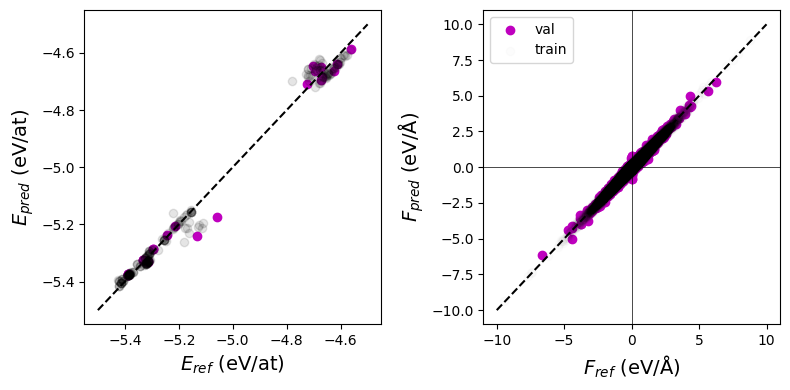

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
plt.sca(axes[0])

per_atom = True
nt = torch.tensor(ref_t.force_ps).flatten()
nv = torch.tensor(ref_v.force_ps).flatten()

ct = "k"
cv = "m"
if per_atom:
    plt.scatter(ref_v.energy / nv, pred_v.energy / nv, label="val", c=cv)
    plt.scatter(ref_t.energy / nt, pred_t.energy / nt, label="train", c=ct, alpha=0.1)
    plt.plot([-5.5, -4.5], [-5.5, -4.5], linestyle="--", color="k");
    plt.xlabel("$E_{ref}$ (eV/at)", size=14)
    plt.ylabel("$E_{pred}$ (eV/at)", size=14);

else:
    plt.scatter(ref_v.energy, pred_v.energy, label="val", c=cv)
    plt.scatter(ref_t.energy, pred_t.energy, label="train", c=ct)
    plt.plot([-500, 0], [-500, 0], linestyle="--", color="k");
    plt.xlabel("$E_{ref}$ (eV)", size=14)
    plt.ylabel("$E_{pred}$ (eV)", size=14);

plt.sca(axes[1])
plt.scatter(ref_v.forces, pred_v.forces, c=cv, label="val");
plt.scatter(ref_t.forces, pred_t.forces, c=ct, label="train", alpha=0.01);

fmax = 10
plt.plot([-fmax, fmax], [-fmax, fmax], linestyle="--", color="k");
plt.axvline(0, color="k", linewidth=0.5)
plt.axhline(0, color="k", linewidth=0.5)
plt.xlabel("$F_{ref}$ (eV/Å)", size=14)
plt.ylabel("$F_{pred}$ (eV/Å)", size=14);
plt.legend()

# plt.ylim(-fmax, fmax)

plt.tight_layout()
plt.show()

And the mean absolute force errors are around 0.06 eV/Å on the validation set:

In [6]:
torch.mean(torch.abs(pred_t.forces - ref_t.forces))

tensor(0.0456)

In [7]:
torch.mean(torch.abs(pred_v.forces - ref_v.forces))

tensor(0.0645)

However, force error distributions are often long-tailed, and it helps to inspect the empirical error cumulative distribution for the force magnitudes:

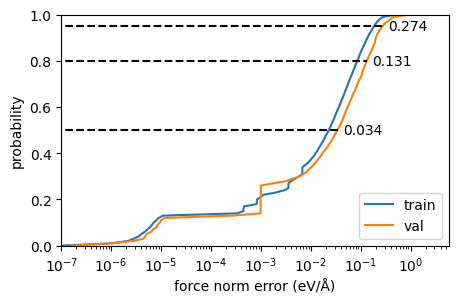

In [8]:
def error_ecdf_plot(inputs, targets, quantiles=[0.5, 0.8, 0.95], annotate=True, label=None):

    ax = plt.gca()

    _y = np.arange(0, 101)
    ecdf = np.percentile((inputs - targets).abs(), _y)

    ax.plot(ecdf, _y/100, label=label)
    ax.set_ylim(0, 1.0)

    if not annotate:
        return ax

    for q in quantiles:
        v = np.percentile((inputs - targets).abs(), 100 * q)
        ax.plot([1e-16, v], [q, q], linestyle="--", color="k")
        ax.annotate(f"{v:.03f}", xy=(1.3 * v, q), va="center")

fig, ax = plt.subplots(figsize=(5,3))
error_ecdf_plot(torch.norm(ref_t.forces, dim=-1), torch.norm(pred_t.forces, dim=-1), annotate=False, label="train")
error_ecdf_plot(torch.norm(ref_v.forces, dim=-1), torch.norm(pred_v.forces, dim=-1),label="val")
ax.semilogx()
ax.set_xlim(1e-7, None)
ax.set_xlabel("force norm error (eV/Å)");
ax.set_ylabel("probability")
ax.legend(loc="lower right");

And the raw force components themselves:

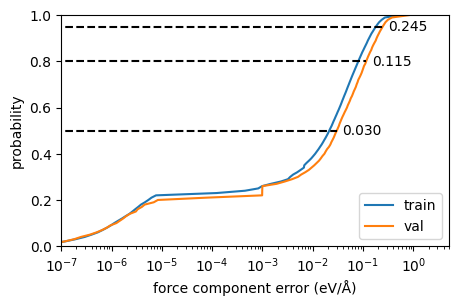

In [9]:
fig, ax = plt.subplots(figsize=(5,3))
error_ecdf_plot(ref_t.forces, pred_t.forces, annotate=False, label="train")
error_ecdf_plot(ref_v.forces, pred_v.forces,label="val")
ax.semilogx()
ax.set_xlim(1e-7, None)
ax.set_xlabel("force component error (eV/Å)");
ax.set_ylabel("probability")
ax.legend(loc="lower right");